# Importing Libraries

In [1]:
# python -m pip install -U matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
import random
import os
from PIL import Image
from glob import glob
import seaborn as sns
import hashlib
import math

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization, Reshape
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

plt.style.use('ggplot')

2025-03-24 11:45:35.578793: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 11:45:35.620643: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Checking Size of the dataset

In [3]:
# List files in the current directory
files = os.listdir("./KaggleCatsDogs")
print(files)

['train_augmented', 'test1', 'train']


In [ ]:
directory_path = "./KaggleCatsDogs"
files = os.listdir(directory_path)

for file in files:
    file_path = os.path.join(directory_path, file)
    
    if os.path.isdir(file_path):
        # Count the number of files inside the directory
        num_files = len(os.listdir(file_path))
        print(f"{file} (Directory) - Number of files inside: {num_files}")

train_augmented (Directory) - Number of files inside: 49910
test1 (Directory) - Number of files inside: 12500
train (Directory) - Number of files inside: 25000


In [5]:
def get_directory_size(directory):
    total_size = 0
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):  # Ensure it's a file
                total_size += os.path.getsize(fp)
    return total_size
 
# print the directory size in MB
size_in_mb = get_directory_size(directory_path) / (1024 * 1024)
print(f"Total size of '{directory_path}': {size_in_mb:.2f} MB")

Total size of './KaggleCatsDogs': 1898.07 MB


In [6]:
img_width=128
img_height=128
img_size=(128,128)
img_channels=3
img_shape = 128,128,3

# Exploring Dataset

In [7]:
cat_files = glob('./KaggleCatsDogs/train/cat.*.jpg')
dog_files = glob('./KaggleCatsDogs/train/dog.*.jpg')
test_files = glob('./KaggleCatsDogs/test1/*.jpg')
train_augmented_files = glob('./KaggleCatsDogs/train_augmented/*.jpeg')

In [8]:
train_augmented_files[:3]

['./KaggleCatsDogs/train_augmented/augmented1_cat.8842_0_8168.jpeg',
 './KaggleCatsDogs/train_augmented/augmented0_dog.2053_0_4862.jpeg',
 './KaggleCatsDogs/train_augmented/augmented0_cat.5535_0_4247.jpeg']

In [9]:
print(dog_files[:3])

['./KaggleCatsDogs/train/dog.4.jpg', './KaggleCatsDogs/train/dog.532.jpg', './KaggleCatsDogs/train/dog.11480.jpg']


In [10]:
print(cat_files[:3])

['./KaggleCatsDogs/train/cat.2071.jpg', './KaggleCatsDogs/train/cat.5517.jpg', './KaggleCatsDogs/train/cat.8220.jpg']


In [11]:
len(cat_files), len(dog_files), len(train_augmented_files)

(12500, 12500, 49910)

In [12]:
# creating train df
# Cat: 0
# Dog: 1
directory_path = "./KaggleCatsDogs/train/"
Directory = os.listdir(directory_path)

labels=[]
for name in Directory:
    label =name.split('.')[0]
    if label=='dog':
        labels.append(1)
    else:
        labels.append(0)

df=pd.DataFrame({
    'filename': ["./KaggleCatsDogs/train/"+path for path in Directory],
    'label': labels
})

In [13]:
df.head()

filename  label
0  ./KaggleCatsDogs/train/cat.2071.jpg      0
1  ./KaggleCatsDogs/train/cat.5517.jpg      0
2  ./KaggleCatsDogs/train/cat.8220.jpg      0
3     ./KaggleCatsDogs/train/dog.4.jpg      1
4   ./KaggleCatsDogs/train/cat.493.jpg      0

In [14]:
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [15]:
# creating augmented df
# Cat: 0
# Dog: 1

directory_path = "./KaggleCatsDogs/train_augmented/"
Directory = os.listdir(directory_path)
# Directory.remove('.ipynb_checkpoints')

labels=[]
for name in Directory:
    label = name.split('.')[0].split('_')[1][:3]
    if label=='dog':
        labels.append(1)
    else:
        labels.append(0)

augmented_df=pd.DataFrame({
    'filename': ["./KaggleCatsDogs/train_augmented/"+path for path in Directory],
    'label': labels
})

In [16]:
augmented_df.head()

filename  label
0  ./KaggleCatsDogs/train_augmented/augmented1_ca...      0
1  ./KaggleCatsDogs/train_augmented/augmented0_do...      1
2  ./KaggleCatsDogs/train_augmented/augmented0_ca...      0
3  ./KaggleCatsDogs/train_augmented/augmented1_do...      1
4  ./KaggleCatsDogs/train_augmented/augmented0_do...      1

In [17]:
augmented_df['label'].value_counts()

1    24970
0    24940
Name: label, dtype: int64

In [18]:
'augmented0_cat.10101_0_7297.jpeg'.split('.')[0].split('_')[1][:3]

'cat'

In [19]:
# creating test df
ids = []
for name in test_files:
    label = name.split('/')[3].split('.')[0]
    ids.append(int(label))

test_df=pd.DataFrame({
    'filename': test_files,
    'id': ids
})

In [20]:
test_df

filename    id
0      ./KaggleCatsDogs/test1/3713.jpg  3713
1      ./KaggleCatsDogs/test1/1664.jpg  1664
2       ./KaggleCatsDogs/test1/131.jpg   131
3      ./KaggleCatsDogs/test1/4370.jpg  4370
4      ./KaggleCatsDogs/test1/9957.jpg  9957
...                                ...   ...
12495  ./KaggleCatsDogs/test1/5890.jpg  5890
12496  ./KaggleCatsDogs/test1/3889.jpg  3889
12497  ./KaggleCatsDogs/test1/7273.jpg  7273
12498  ./KaggleCatsDogs/test1/7260.jpg  7260
12499  ./KaggleCatsDogs/test1/2910.jpg  2910

[12500 rows x 2 columns]

In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12500 non-null  object
 1   id        12500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 195.4+ KB


**Taking random images from all the images**

In [22]:
# sample image
random_num = random.randint(0, 12499)
img_mpl = plt.imread(dog_files[random_num])
img_cv2 = cv2.imread(dog_files[random_num])

In [23]:
img_mpl.shape

(370, 500, 3)

img_mpl.flatten() -> will flatten the array into 1 row arr of pixel values

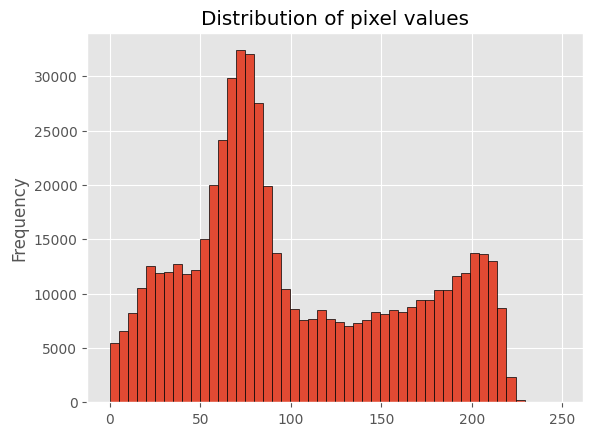

In [24]:
pd.Series(img_mpl.flatten()).plot(kind='hist', bins=50, edgecolor='black', title='Distribution of pixel values')
plt.show()

**Display Images**

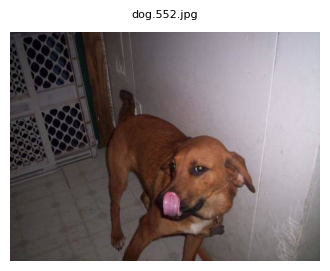

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_mpl)
ax.set_title(dog_files[random_num].split('/')[3], fontsize=8, pad=10)
ax.axis('off')
plt.show()

Looking at the channels

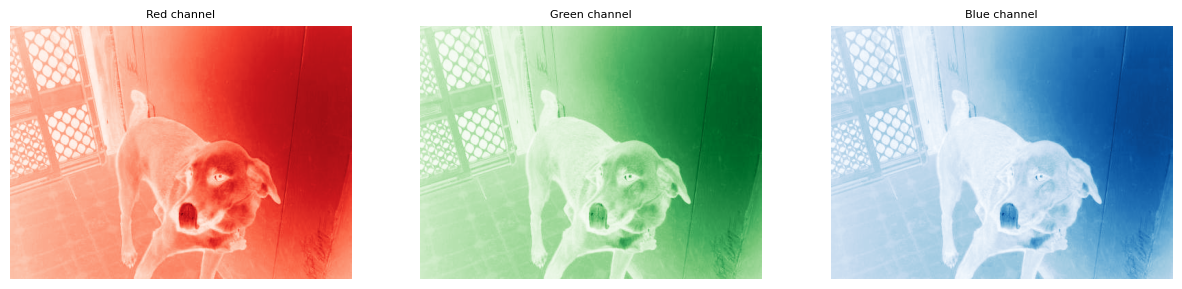

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_mpl[:,:,0], cmap='Reds')
axs[1].imshow(img_mpl[:,:,1], cmap='Greens')
axs[2].imshow(img_mpl[:,:,2], cmap='Blues')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Red channel', fontsize=8)
axs[1].set_title('Green channel', fontsize=8)
axs[2].set_title('Blue channel', fontsize=8)
plt.show()

In [27]:
def display_images(files):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))  # adjust figsize as needed
    
    index = random.sample(range(0,12499), 5)
    images = [files[i] for i in index]
    
    for ax, path in zip(axes, images):
        img = plt.imread(path)
        ax.imshow(img)
        ax.set_title(path.split('/')[3], fontsize=8, pad=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

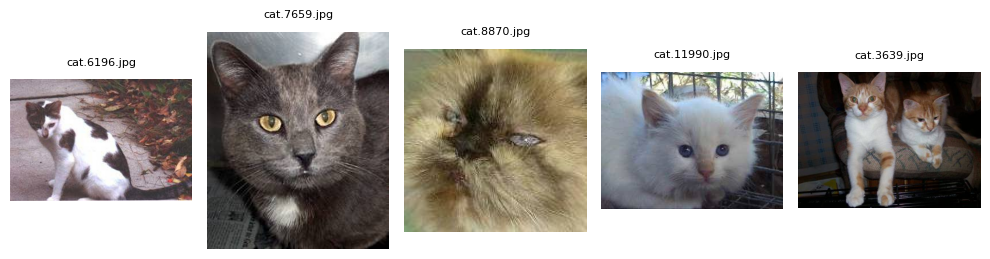

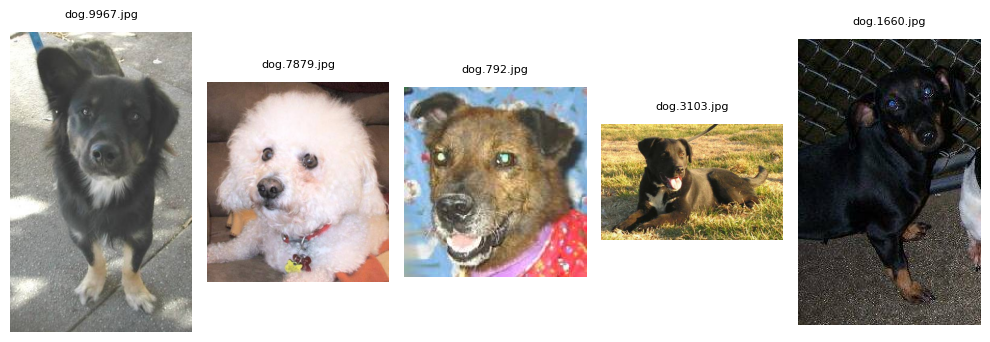

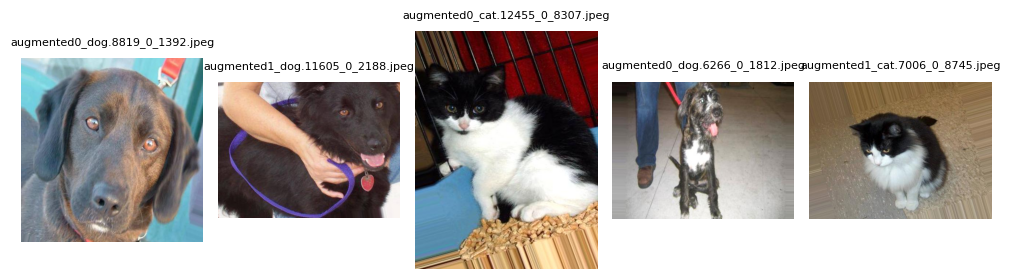

In [28]:
display_images(cat_files)
display_images(dog_files)
display_images(train_augmented_files)

MPL vs CV2

* MPL: displays images in RGB
* CV2: displays images as BGR 

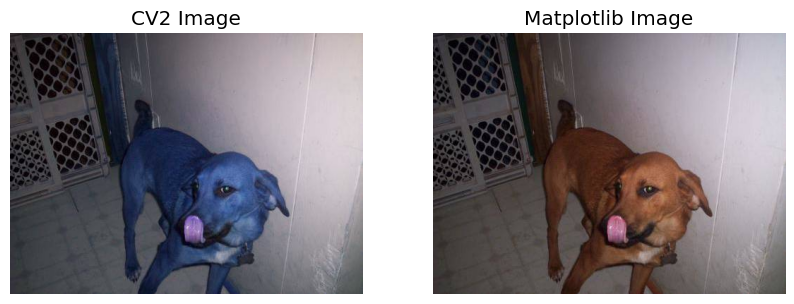

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_cv2)
axs[1].imshow(img_mpl)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('CV2 Image')
axs[1].set_title('Matplotlib Image')
plt.show()

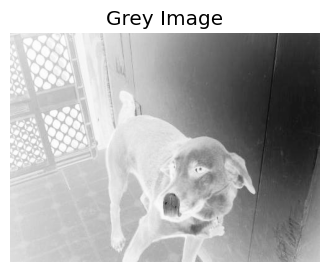

In [30]:
img_gray = cv2.cvtColor(img_mpl, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_gray, cmap='Greys')
ax.axis('off')
ax.set_title('Grey Image')
plt.show()

**checking size distribution of the images**

In [31]:
def check_size(directory_path):
    file_list = os.listdir(directory_path)
    # store image dimensions
    image_shapes = []
    
    for file in file_list:
        file_path = os.path.join(directory_path, file)
        
        try:
            img = Image.open(file_path)
            image_shapes.append(img.size)  # (width, height)
        except:
            print(f"Error loading image: {file}")
    
    # convert to DataFrame for analysis
    df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
    print(f'\ninside directory: {directory_path}')
    print(df_shapes.describe())  # Summary statistics


In [32]:
check_size('./KaggleCatsDogs/train/')
check_size('./KaggleCatsDogs/test1/')


inside directory: ./KaggleCatsDogs/train/
             Width        Height
count  25000.00000  25000.000000
mean     404.09904    360.478080
std      109.03793     97.019959
min       42.00000     32.000000
25%      323.00000    301.000000
50%      447.00000    374.000000
75%      499.00000    421.000000
max     1050.00000    768.000000

inside directory: ./KaggleCatsDogs/test1/
              Width        Height
count  12500.000000  12500.000000
mean     404.224480    359.930720
std      109.330874     96.757411
min       37.000000     44.000000
25%      329.000000    300.000000
50%      447.000000    374.000000
75%      499.000000    418.000000
max      500.000000    500.000000


**checking color channel of all the images**

In [33]:
def check_color_channel(directory_path):
    file_list = os.listdir(directory_path)
    modes = []
    
    for file in file_list:
        file_path = os.path.join(directory_path, file)
        try:
            img = Image.open(file_path)
            modes.append(img.mode)
        except Exception as e:
            print(f"Error loading image {file}: {e}")
    
    # Create a DataFrame for analysis
    df_modes = pd.DataFrame(modes, columns=["Mode"])
    print(f'\ninside directory: {directory_path}')
    print(df_modes["Mode"].value_counts())

In [34]:
check_color_channel('./KaggleCatsDogs/train/')
check_color_channel('./KaggleCatsDogs/test1/')


inside directory: ./KaggleCatsDogs/train/
RGB    25000
Name: Mode, dtype: int64

inside directory: ./KaggleCatsDogs/test1/
RGB    12500
Name: Mode, dtype: int64


All the images are in RGB Mode

**Visualizing class distribution**

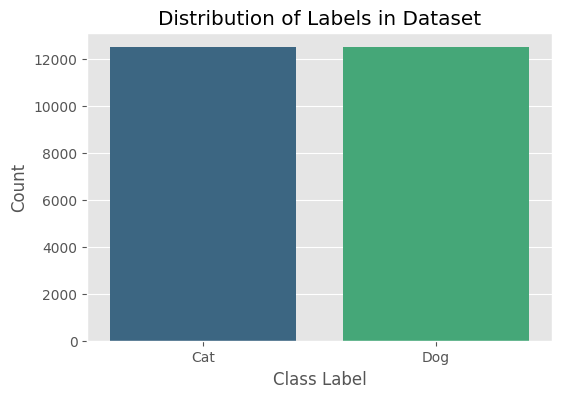

In [35]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)

plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in Dataset")
plt.xticks(ticks=[0,1], labels=["Cat", "Dog"])  # Adjust labels if needed

plt.show()

**checking for duplicates**

In [36]:
def get_image_hash(image_path):
    """
    Open the image file and compute an MD5 hash of its bytes.
    """
    try:
        # Open image in binary mode
        with open(image_path, "rb") as f:
            file_bytes = f.read()
            # Compute MD5 hash
            image_hash = hashlib.md5(file_bytes).hexdigest()
        return image_hash
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [37]:
def check_duplicates(dataframe):
    file_list = dataframe['filename']
    
    # Dictionary to store hash as key and list of corresponding filenames as value.
    hash_dict = {}
    
    for file_path in file_list:
        image_hash = get_image_hash(file_path)
        
        # Skip if image could not be processed.
        if image_hash is None:
            continue
    
        # Append filename to list corresponding to the hash.
        if image_hash in hash_dict:
            hash_dict[image_hash].append(file_path)
        else:
            hash_dict[image_hash] = [file_path]

    duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

    print(f"Found {len(duplicates)} duplicate groups.")
    for image_hash, files in duplicates.items():
        print(f"Hash: {image_hash} -> Files: {files}")

    remove_files = []
    for i in duplicates.values():
        for j in i[1:]:
            remove_files += [j]
    return remove_files

In [38]:
def remove_duplicates(duplicate_files, dataframe):
    
    # remove rows where the filename is in the list of files to remove
    print('removed following files:')
    # print(duplicate_files)
    # pretty print
    for file in duplicate_files:
        print(file)
    return dataframe[~dataframe['filename'].isin(duplicate_files)]
    

In [39]:
# checking and removing duplicates from train set
print('duplicates in train set')
train_duplicates = check_duplicates(df)

duplicates in train set
Found 5 duplicate groups.
Hash: 61d6a61e883505354ef4357c292d779a -> Files: ['./KaggleCatsDogs/train/dog.10401.jpg', './KaggleCatsDogs/train/dog.2877.jpg', './KaggleCatsDogs/train/dog.10797.jpg']
Hash: f82f16242edc7dd89e65899e33785fa2 -> Files: ['./KaggleCatsDogs/train/cat.6204.jpg', './KaggleCatsDogs/train/cat.6143.jpg']
Hash: 1ae75ef04bfbd4d81d0bf714769ef5d3 -> Files: ['./KaggleCatsDogs/train/cat.10360.jpg', './KaggleCatsDogs/train/cat.3345.jpg']
Hash: fcfadc8c513ce6a8010abf9feea9ee00 -> Files: ['./KaggleCatsDogs/train/cat.12408.jpg', './KaggleCatsDogs/train/cat.2339.jpg']
Hash: 4184ca4717aa35e8b7aa72f88923e57c -> Files: ['./KaggleCatsDogs/train/dog.3082.jpg', './KaggleCatsDogs/train/dog.2027.jpg']


In [40]:
df = remove_duplicates(train_duplicates, df)

removed following files:
./KaggleCatsDogs/train/dog.2877.jpg
./KaggleCatsDogs/train/dog.10797.jpg
./KaggleCatsDogs/train/cat.6143.jpg
./KaggleCatsDogs/train/cat.3345.jpg
./KaggleCatsDogs/train/cat.2339.jpg
./KaggleCatsDogs/train/dog.2027.jpg


In [41]:
print('duplicates in train set')
check_duplicates(df)

duplicates in train set
Found 0 duplicate groups.


[]

Training set duplicates removed

In [42]:
# checking train set
df['label'].value_counts()

0    12497
1    12497
Name: label, dtype: int64

In [43]:
# checking and removing duplicates from test set
print('duplicates in test set')
test_duplicates = check_duplicates(test_df)

duplicates in test set


Found 49 duplicate groups.
Hash: 44c806ebf1c024233d80b1ed49484a54 -> Files: ['./KaggleCatsDogs/test1/6383.jpg', './KaggleCatsDogs/test1/2421.jpg', './KaggleCatsDogs/test1/1265.jpg', './KaggleCatsDogs/test1/11779.jpg', './KaggleCatsDogs/test1/11276.jpg']
Hash: 129952a014540ab66eae767737fb1551 -> Files: ['./KaggleCatsDogs/test1/5545.jpg', './KaggleCatsDogs/test1/4061.jpg', './KaggleCatsDogs/test1/1111.jpg']
Hash: 7d343bdf423cc19756ebf299d3e0b320 -> Files: ['./KaggleCatsDogs/test1/2864.jpg', './KaggleCatsDogs/test1/11277.jpg']
Hash: b4d83fc5bfce368a846b5274c2ebfa68 -> Files: ['./KaggleCatsDogs/test1/6013.jpg', './KaggleCatsDogs/test1/7325.jpg']
Hash: df067884222a4cb3b598536779bf63fa -> Files: ['./KaggleCatsDogs/test1/1091.jpg', './KaggleCatsDogs/test1/4511.jpg']
Hash: ccaeb98b1d5f29e945f87ba30c006a5c -> Files: ['./KaggleCatsDogs/test1/2162.jpg', './KaggleCatsDogs/test1/8318.jpg']
Hash: 2b4b39159d2fb1bf809ff1a98cf93182 -> Files: ['./KaggleCatsDogs/test1/12050.jpg', './KaggleCatsDogs/test1/

In [44]:
test_df = remove_duplicates(test_duplicates, test_df)

removed following files:
./KaggleCatsDogs/test1/2421.jpg
./KaggleCatsDogs/test1/1265.jpg
./KaggleCatsDogs/test1/11779.jpg
./KaggleCatsDogs/test1/11276.jpg
./KaggleCatsDogs/test1/4061.jpg
./KaggleCatsDogs/test1/1111.jpg
./KaggleCatsDogs/test1/11277.jpg
./KaggleCatsDogs/test1/7325.jpg
./KaggleCatsDogs/test1/4511.jpg
./KaggleCatsDogs/test1/8318.jpg
./KaggleCatsDogs/test1/10274.jpg
./KaggleCatsDogs/test1/8377.jpg
./KaggleCatsDogs/test1/6285.jpg
./KaggleCatsDogs/test1/10422.jpg
./KaggleCatsDogs/test1/3464.jpg
./KaggleCatsDogs/test1/5459.jpg
./KaggleCatsDogs/test1/750.jpg
./KaggleCatsDogs/test1/6044.jpg
./KaggleCatsDogs/test1/3214.jpg
./KaggleCatsDogs/test1/1583.jpg
./KaggleCatsDogs/test1/10327.jpg
./KaggleCatsDogs/test1/8104.jpg
./KaggleCatsDogs/test1/518.jpg
./KaggleCatsDogs/test1/3050.jpg
./KaggleCatsDogs/test1/2140.jpg
./KaggleCatsDogs/test1/7780.jpg
./KaggleCatsDogs/test1/7032.jpg
./KaggleCatsDogs/test1/2629.jpg
./KaggleCatsDogs/test1/9192.jpg
./KaggleCatsDogs/test1/4282.jpg
./KaggleCat

In [45]:
print('duplicates in test set')
check_duplicates(test_df)

duplicates in test set


Found 0 duplicate groups.


[]

Test set duplicates removed

In [46]:
test_df.head()

filename    id
0  ./KaggleCatsDogs/test1/3713.jpg  3713
1  ./KaggleCatsDogs/test1/1664.jpg  1664
2   ./KaggleCatsDogs/test1/131.jpg   131
3  ./KaggleCatsDogs/test1/4370.jpg  4370
4  ./KaggleCatsDogs/test1/9957.jpg  9957

In [47]:
# checking duplicates in the train and test set combined

combined_filenames = pd.concat([test_df['filename'], df['filename']], ignore_index=True)
combined_df = pd.DataFrame({'filename': combined_filenames})

print('duplicates in combined set')
train_test_duplicates = check_duplicates(combined_df)

duplicates in combined set
Found 39 duplicate groups.
Hash: 3c162e924398e705b6648a646d12cd35 -> Files: ['./KaggleCatsDogs/test1/12072.jpg', './KaggleCatsDogs/train/cat.11840.jpg']
Hash: 5af4d8e7173015cdfe063172e185adc2 -> Files: ['./KaggleCatsDogs/test1/7824.jpg', './KaggleCatsDogs/train/cat.360.jpg']
Hash: b76b267329ce1f1ee2191b93cde8d617 -> Files: ['./KaggleCatsDogs/test1/11204.jpg', './KaggleCatsDogs/train/dog.9927.jpg']
Hash: 40e01568d18ed59dd518c3402a261968 -> Files: ['./KaggleCatsDogs/test1/5818.jpg', './KaggleCatsDogs/train/cat.2575.jpg']
Hash: b11848794873c1c9a75897ffa752d359 -> Files: ['./KaggleCatsDogs/test1/4775.jpg', './KaggleCatsDogs/train/cat.7206.jpg']
Hash: ee9ce4e514170944816fd0064c8c2f82 -> Files: ['./KaggleCatsDogs/test1/9465.jpg', './KaggleCatsDogs/train/dog.4805.jpg']
Hash: 78d3762108bd362d005e80d342b27c36 -> Files: ['./KaggleCatsDogs/test1/5598.jpg', './KaggleCatsDogs/train/cat.8091.jpg']
Hash: 2b6d4654e8426a2125a3be0688e8046e -> Files: ['./KaggleCatsDogs/test1/85

In [48]:
train_test_duplicates

['./KaggleCatsDogs/train/cat.11840.jpg',
 './KaggleCatsDogs/train/cat.360.jpg',
 './KaggleCatsDogs/train/dog.9927.jpg',
 './KaggleCatsDogs/train/cat.2575.jpg',
 './KaggleCatsDogs/train/cat.7206.jpg',
 './KaggleCatsDogs/train/dog.4805.jpg',
 './KaggleCatsDogs/train/cat.8091.jpg',
 './KaggleCatsDogs/train/cat.10127.jpg',
 './KaggleCatsDogs/train/cat.6852.jpg',
 './KaggleCatsDogs/train/cat.11218.jpg',
 './KaggleCatsDogs/train/cat.11565.jpg',
 './KaggleCatsDogs/train/dog.10401.jpg',
 './KaggleCatsDogs/train/cat.4989.jpg',
 './KaggleCatsDogs/train/cat.5624.jpg',
 './KaggleCatsDogs/train/cat.3842.jpg',
 './KaggleCatsDogs/train/cat.4517.jpg',
 './KaggleCatsDogs/train/cat.11773.jpg',
 './KaggleCatsDogs/train/dog.2265.jpg',
 './KaggleCatsDogs/train/cat.730.jpg',
 './KaggleCatsDogs/train/dog.7020.jpg',
 './KaggleCatsDogs/train/cat.6096.jpg',
 './KaggleCatsDogs/train/cat.10238.jpg',
 './KaggleCatsDogs/train/cat.901.jpg',
 './KaggleCatsDogs/train/dog.4097.jpg',
 './KaggleCatsDogs/train/cat.5741.jp

In [49]:
test_df = remove_duplicates(train_test_duplicates, test_df)

removed following files:
./KaggleCatsDogs/train/cat.11840.jpg
./KaggleCatsDogs/train/cat.360.jpg
./KaggleCatsDogs/train/dog.9927.jpg
./KaggleCatsDogs/train/cat.2575.jpg
./KaggleCatsDogs/train/cat.7206.jpg
./KaggleCatsDogs/train/dog.4805.jpg
./KaggleCatsDogs/train/cat.8091.jpg
./KaggleCatsDogs/train/cat.10127.jpg
./KaggleCatsDogs/train/cat.6852.jpg
./KaggleCatsDogs/train/cat.11218.jpg
./KaggleCatsDogs/train/cat.11565.jpg
./KaggleCatsDogs/train/dog.10401.jpg
./KaggleCatsDogs/train/cat.4989.jpg
./KaggleCatsDogs/train/cat.5624.jpg
./KaggleCatsDogs/train/cat.3842.jpg
./KaggleCatsDogs/train/cat.4517.jpg
./KaggleCatsDogs/train/cat.11773.jpg
./KaggleCatsDogs/train/dog.2265.jpg
./KaggleCatsDogs/train/cat.730.jpg
./KaggleCatsDogs/train/dog.7020.jpg
./KaggleCatsDogs/train/cat.6096.jpg
./KaggleCatsDogs/train/cat.10238.jpg
./KaggleCatsDogs/train/cat.901.jpg
./KaggleCatsDogs/train/dog.4097.jpg
./KaggleCatsDogs/train/cat.5741.jpg
./KaggleCatsDogs/train/dog.347.jpg
./KaggleCatsDogs/train/cat.846.jpg
.

In [50]:
# checking again for combined set

combined_filenames = pd.concat([test_df['filename'], df['filename']], ignore_index=True)
combined_df = pd.DataFrame({'filename': combined_filenames})

print('duplicates in combined set')
train_test_duplicates = check_duplicates(combined_df)

duplicates in combined set


Found 39 duplicate groups.
Hash: 3c162e924398e705b6648a646d12cd35 -> Files: ['./KaggleCatsDogs/test1/12072.jpg', './KaggleCatsDogs/train/cat.11840.jpg']
Hash: 5af4d8e7173015cdfe063172e185adc2 -> Files: ['./KaggleCatsDogs/test1/7824.jpg', './KaggleCatsDogs/train/cat.360.jpg']
Hash: b76b267329ce1f1ee2191b93cde8d617 -> Files: ['./KaggleCatsDogs/test1/11204.jpg', './KaggleCatsDogs/train/dog.9927.jpg']
Hash: 40e01568d18ed59dd518c3402a261968 -> Files: ['./KaggleCatsDogs/test1/5818.jpg', './KaggleCatsDogs/train/cat.2575.jpg']
Hash: b11848794873c1c9a75897ffa752d359 -> Files: ['./KaggleCatsDogs/test1/4775.jpg', './KaggleCatsDogs/train/cat.7206.jpg']
Hash: ee9ce4e514170944816fd0064c8c2f82 -> Files: ['./KaggleCatsDogs/test1/9465.jpg', './KaggleCatsDogs/train/dog.4805.jpg']
Hash: 78d3762108bd362d005e80d342b27c36 -> Files: ['./KaggleCatsDogs/test1/5598.jpg', './KaggleCatsDogs/train/cat.8091.jpg']
Hash: 2b6d4654e8426a2125a3be0688e8046e -> Files: ['./KaggleCatsDogs/test1/8513.jpg', './KaggleCatsDogs/

In [51]:
test_df.shape

(12437, 2)

In [52]:
df = remove_duplicates(train_test_duplicates, df)

removed following files:
./KaggleCatsDogs/train/cat.11840.jpg
./KaggleCatsDogs/train/cat.360.jpg
./KaggleCatsDogs/train/dog.9927.jpg
./KaggleCatsDogs/train/cat.2575.jpg
./KaggleCatsDogs/train/cat.7206.jpg
./KaggleCatsDogs/train/dog.4805.jpg
./KaggleCatsDogs/train/cat.8091.jpg
./KaggleCatsDogs/train/cat.10127.jpg
./KaggleCatsDogs/train/cat.6852.jpg
./KaggleCatsDogs/train/cat.11218.jpg
./KaggleCatsDogs/train/cat.11565.jpg
./KaggleCatsDogs/train/dog.10401.jpg
./KaggleCatsDogs/train/cat.4989.jpg
./KaggleCatsDogs/train/cat.5624.jpg
./KaggleCatsDogs/train/cat.3842.jpg
./KaggleCatsDogs/train/cat.4517.jpg
./KaggleCatsDogs/train/cat.11773.jpg
./KaggleCatsDogs/train/dog.2265.jpg
./KaggleCatsDogs/train/cat.730.jpg
./KaggleCatsDogs/train/dog.7020.jpg
./KaggleCatsDogs/train/cat.6096.jpg
./KaggleCatsDogs/train/cat.10238.jpg
./KaggleCatsDogs/train/cat.901.jpg
./KaggleCatsDogs/train/dog.4097.jpg
./KaggleCatsDogs/train/cat.5741.jpg
./KaggleCatsDogs/train/dog.347.jpg
./KaggleCatsDogs/train/cat.846.jpg
.

**merging train and augmented dataset** 

In [53]:
augmented_df.head()

filename  label
0  ./KaggleCatsDogs/train_augmented/augmented1_ca...      0
1  ./KaggleCatsDogs/train_augmented/augmented0_do...      1
2  ./KaggleCatsDogs/train_augmented/augmented0_ca...      0
3  ./KaggleCatsDogs/train_augmented/augmented1_do...      1
4  ./KaggleCatsDogs/train_augmented/augmented0_do...      1

In [54]:
df.head()

filename  label
0  ./KaggleCatsDogs/train/cat.2071.jpg      0
1  ./KaggleCatsDogs/train/cat.5517.jpg      0
2  ./KaggleCatsDogs/train/cat.8220.jpg      0
3     ./KaggleCatsDogs/train/dog.4.jpg      1
4   ./KaggleCatsDogs/train/cat.493.jpg      0

In [55]:
df = pd.concat([df, augmented_df], axis=0, ignore_index=True)

In [56]:
df.tail()

filename  label
74860  ./KaggleCatsDogs/train_augmented/augmented1_ca...      0
74861  ./KaggleCatsDogs/train_augmented/augmented1_ca...      0
74862  ./KaggleCatsDogs/train_augmented/augmented0_ca...      0
74863  ./KaggleCatsDogs/train_augmented/augmented1_do...      1
74864  ./KaggleCatsDogs/train_augmented/augmented1_ca...      0

In [57]:
df['label'].value_counts()

1    37455
0    37410
Name: label, dtype: int64

# Preprocessing Image

## Data generation - offline for testing

In [58]:
# # checking output folder
# augmented_data_folder = './KaggleCatsDogs/train augmented'

In [59]:
# datagen = ImageDataGenerator(
#     rotation_range=30,        # Rotate images by up to 30 degrees
#     # width_shift_range=0.2,    # Shift image horizontally (20% of width)
#     # height_shift_range=0.2,   # Shift image vertically (20% of height)
#     # shear_range=0.2,          # Shear transformation
#     zoom_range=0.2,           # Random zoom up to 20%
#     horizontal_flip=True,     # Flip images horizontally
#     brightness_range=[0.8, 1.2],  # Random brightness adjustment
#     fill_mode='nearest'       # Fill missing pixels
# )

In [60]:
# # Load an image (replace with your image path)
# img_path = cat_files[0]  # Change this to your image path
# img = load_img(img_path)  # Load image
# img_array = img_to_array(img)  # Convert to NumPy array
# img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch

# # Generate augmented images and save them
# image_prefix = "augmented_cat"  # Prefix for saved images

# aug_iter = datagen.flow(
#     img_array,
#     batch_size=1,
#     save_to_dir=augmented_data_folder,  # Folder to save images
#     save_prefix=image_prefix,   # Prefix for filenames
#     save_format='jpg'           # Format of saved images
# )

# # Generate & save 10 augmented images
# for i in range(10):  
#     next(aug_iter)  # Generate and save images automatically

# print(f"Augmented images saved in '{augmented_data_folder}' folder.")


## data Generation - Online

It minimizes disk usage and provides dynamic, varied augmentations during each training epoch.

In [61]:
# datagen = ImageDataGenerator(
#     rotation_range=30,        # Rotate images by up to 30 degrees
#     # width_shift_range=0.2,    # Shift image horizontally (20% of width)
#     # height_shift_range=0.2,   # Shift image vertically (20% of height)
#     # shear_range=0.2,          # Shear transformation
#     zoom_range=0.2,           # Random zoom up to 20%
#     horizontal_flip=True,     # Flip images horizontally
#     brightness_range=[0.8, 1.2],  # Random brightness adjustment
#     fill_mode='nearest'       # Fill missing pixels
# )

## Data conversion

convert cv2 color to RGB

resize every image to 128,128

normalize images

In [62]:
x_train = []
for img in df['filename']:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img/255.0
    x_train.append(img)
x_train = np.array(x_train)

In [63]:
y_train = df[['label']]

In [64]:
x_train.shape, y_train.shape

((74865, 128, 128, 3), (74865, 1))

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Model creation

## Model 1

In [66]:
model = Sequential()

2025-03-24 11:47:28.323120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41793 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:61:00.0, compute capability: 8.9


In [67]:
# cnn layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=img_shape))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))


In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [69]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [70]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=36,verbose=1)

Epoch 1/20


2025-03-24 11:47:44.377382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2025-03-24 11:47:44.592496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-03-24 11:47:44.654516: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff770609e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-24 11:47:44.654549: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-24 11:47:44.660887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-24 11:47:44.816508: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1664/1664 [==============================] - 20s 10ms/step - loss: 0.5579 - accuracy: 0.7111 - val_loss: 0.4853 - val_accuracy: 0.7673
Epoch 2/20
1664/1664 [==============================] - 13s 8ms/step - loss: 0.4256 - accuracy: 0.8032 - val_loss: 0.4413 - val_accuracy: 0.7959
Epoch 3/20
1664/1664 [==============================] - 12s 7ms/step - loss: 0.3225 - accuracy: 0.8595 - val_loss: 0.4463 - val_accuracy: 0.8067
Epoch 4/20
1664/1664 [==============================] - 13s 8ms/step - loss: 0.1970 - accuracy: 0.9196 - val_loss: 0.5327 - val_accuracy: 0.8014
Epoch 5/20
1664/1664 [==============================] - 13s 8ms/step - loss: 0.0972 - accuracy: 0.9643 - val_loss: 0.6849 - val_accuracy: 0.8000
Epoch 6/20
1664/1664 [==============================] - 12s 7ms/step - loss: 0.0577 - accuracy: 0.9795 - val_loss: 0.9807 - val_accuracy: 0.7890
Epoch 7/20
1664/1664 [==============================] - 12s 7ms/step - loss: 0.0419 - accuracy: 0.9857 - val_loss: 0.9696 - val_accuracy: 0.

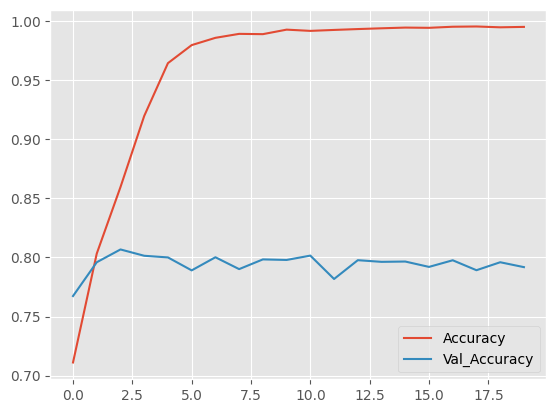

In [71]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();

In [72]:
model.evaluate(x_test, y_test)

468/468 [==============================] - 2s 4ms/step - loss: 1.7198 - accuracy: 0.7918


[1.719820261001587, 0.7917584776878357]

## Model 2

In [73]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=2):
    model = keras.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),  # Dropout to prevent overfitting

        # Convolutional Layer 2
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Convolutional Layer 3
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Stronger dropout at dense layer
        layers.Dense(num_classes, activation='softmax')  # Softmax for classification
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [74]:
# early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [75]:
cnn_model = create_cnn_model()
cnn_model.summary()  # Print model summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)       

In [76]:
cnn_model_history = cnn_model.fit(x_train, y_train, 
                                validation_data=(x_test, y_test), 
                                epochs=25, 
                                batch_size=32, 
                                callbacks=[early_stopping], 
                                verbose=1)

Epoch 1/25


2025-03-24 11:52:21.809395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1872/1872 [==============================] - 21s 10ms/step - loss: 0.6479 - accuracy: 0.6049 - val_loss: 0.5655 - val_accuracy: 0.7117
Epoch 2/25
1872/1872 [==============================] - 15s 8ms/step - loss: 0.5221 - accuracy: 0.7391 - val_loss: 0.4670 - val_accuracy: 0.7773
Epoch 3/25
1872/1872 [==============================] - 15s 8ms/step - loss: 0.4600 - accuracy: 0.7856 - val_loss: 0.4070 - val_accuracy: 0.8142
Epoch 4/25
1872/1872 [==============================] - 15s 8ms/step - loss: 0.4206 - accuracy: 0.8093 - val_loss: 0.3967 - val_accuracy: 0.8205
Epoch 5/25
1872/1872 [==============================] - 15s 8ms/step - loss: 0.3882 - accuracy: 0.8252 - val_loss: 0.3452 - val_accuracy: 0.8473
Epoch 6/25
1872/1872 [==============================] - 15s 8ms/step - loss: 0.3668 - accuracy: 0.8389 - val_loss: 0.3221 - val_accuracy: 0.8630
Epoch 7/25
1872/1872 [==============================] - 16s 8ms/step - loss: 0.3480 - accuracy: 0.8493 - val_loss: 0.3070 - val_accuracy: 0.

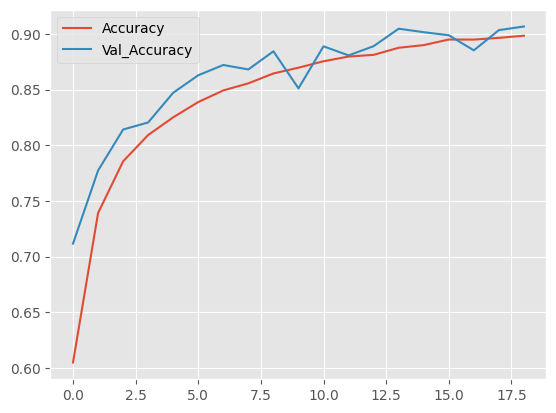

In [77]:
plt.plot(cnn_model_history.history['accuracy'],label='Accuracy')
plt.plot(cnn_model_history.history['val_accuracy'],label='Val_Accuracy')
plt.legend()

## Model 3

# Model Testing

## Model 1

In [78]:
test_df= test_df.sort_values(by='id', ascending=True)

In [79]:
test_df.head()

filename  id
6030   ./KaggleCatsDogs/test1/1.jpg   1
2362   ./KaggleCatsDogs/test1/2.jpg   2
5440   ./KaggleCatsDogs/test1/3.jpg   3
5877   ./KaggleCatsDogs/test1/4.jpg   4
11145  ./KaggleCatsDogs/test1/5.jpg   5

In [80]:
x_test=[]
for img in test_df['filename']:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img/255.0
    x_test.append(img)
x_test=np.array(x_test)

In [81]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=-1)
predictions = np.array(predictions)

389/389 [==============================] - 1s 3ms/step


In [82]:
pred=pd.DataFrame({
    'id':test_df['id'],
    'filename':test_df['filename'],
    'label':predictions
})

In [83]:
pred.head(15)

id                       filename  label
6030    1   ./KaggleCatsDogs/test1/1.jpg      1
2362    2   ./KaggleCatsDogs/test1/2.jpg      1
5440    3   ./KaggleCatsDogs/test1/3.jpg      1
5877    4   ./KaggleCatsDogs/test1/4.jpg      1
11145   5   ./KaggleCatsDogs/test1/5.jpg      0
5101    6   ./KaggleCatsDogs/test1/6.jpg      1
12395   7   ./KaggleCatsDogs/test1/7.jpg      0
2990    8   ./KaggleCatsDogs/test1/8.jpg      1
4706    9   ./KaggleCatsDogs/test1/9.jpg      0
5602   10  ./KaggleCatsDogs/test1/10.jpg      0
6723   11  ./KaggleCatsDogs/test1/11.jpg      0
6859   12  ./KaggleCatsDogs/test1/12.jpg      1
8350   13  ./KaggleCatsDogs/test1/13.jpg      0
7142   14  ./KaggleCatsDogs/test1/14.jpg      1
1562   15  ./KaggleCatsDogs/test1/15.jpg      0

In [84]:
def display_pred_images(pred):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))  # adjust figsize as needed
    
    index = random.sample(range(0,12499), 5)
    images = [pred['filename'].iloc[i] for i in index]
    
    print('Cat: 0\nDog: 1')
    for ax, path in zip(axes, images):
        img = plt.imread(path)
        img_id = path.split('/')[3]
        ax.imshow(img)
        ax.set_title(img_id + '\npred: ' + str(pred['label'].iloc[int(img_id.split('.')[0])]) , fontsize=8, pad=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Cat: 0
Dog: 1


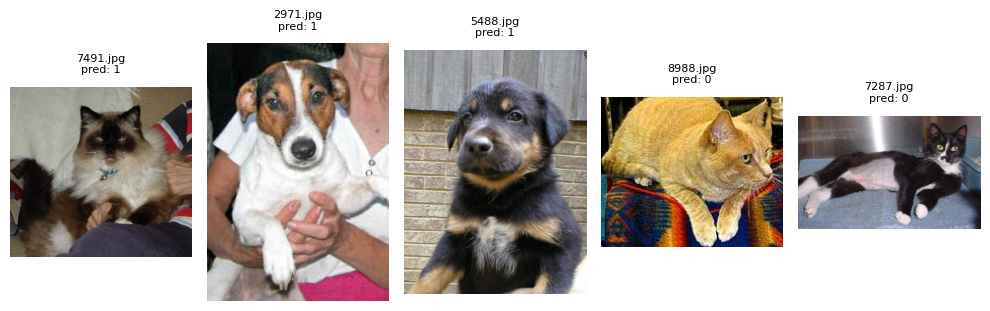

In [85]:
display_pred_images(pred)

## Model 2

In [86]:
# testing 2nd model
cnn_predictions = cnn_model.predict(x_test)
cnn_predictions = cnn_predictions.argmax(axis=-1)
cnn_predictions = np.array(cnn_predictions)

389/389 [==============================] - 1s 3ms/step


In [87]:
cnn_pred=pd.DataFrame({
    'id':test_df['id'],
    'filename':test_df['filename'],
    'label':cnn_predictions
})

Cat: 0
Dog: 1


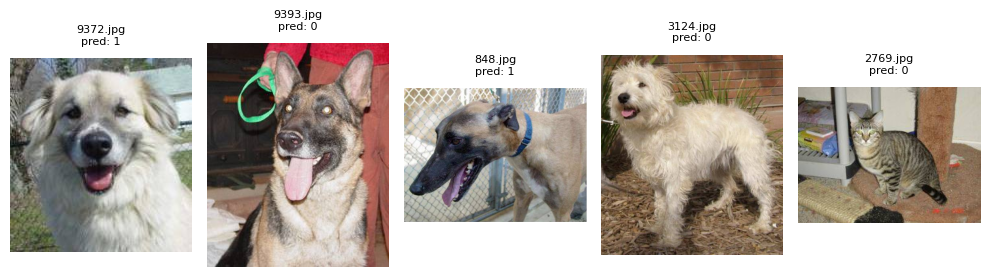

In [88]:
display_pred_images(cnn_pred)

In [89]:
cnn_pred.head(15)

id                       filename  label
6030    1   ./KaggleCatsDogs/test1/1.jpg      1
2362    2   ./KaggleCatsDogs/test1/2.jpg      1
5440    3   ./KaggleCatsDogs/test1/3.jpg      1
5877    4   ./KaggleCatsDogs/test1/4.jpg      1
11145   5   ./KaggleCatsDogs/test1/5.jpg      0
5101    6   ./KaggleCatsDogs/test1/6.jpg      0
12395   7   ./KaggleCatsDogs/test1/7.jpg      0
2990    8   ./KaggleCatsDogs/test1/8.jpg      0
4706    9   ./KaggleCatsDogs/test1/9.jpg      0
5602   10  ./KaggleCatsDogs/test1/10.jpg      0
6723   11  ./KaggleCatsDogs/test1/11.jpg      0
6859   12  ./KaggleCatsDogs/test1/12.jpg      1
8350   13  ./KaggleCatsDogs/test1/13.jpg      0
7142   14  ./KaggleCatsDogs/test1/14.jpg      0
1562   15  ./KaggleCatsDogs/test1/15.jpg      0

In [90]:
cnn_model.save('image-classification-model')  # Saves in TensorFlow format

INFO:tensorflow:Assets written to: image-classification-model/assets


INFO:tensorflow:Assets written to: image-classification-model/assets


# Random Testing

In [91]:
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# Get image and kernel sizes
img_h, img_w = img_gray.shape
ker_h, ker_w = kernel.shape

# Define output size (without padding)
output_h = img_h - ker_h + 1
output_w = img_w - ker_w + 1

# Initialize the output feature map
output = np.zeros((output_h, output_w))

# Perform convolution operation manually
for i in range(output_h):
    for j in range(output_w):
        region = img_gray[i:i+ker_h, j:j+ker_w]  # Extract the 3x3 region
        output[i, j] = np.sum(region * kernel)  # Element-wise multiplication and sum

print("Output Feature Map:")
print(output)

Output Feature Map:
[[12.  4. -6. ...  1.  6.  7.]
 [14. 13.  6. ...  1.  6.  7.]
 [ 9. 10.  6. ...  1.  6.  7.]
 ...
 [-3. -3.  0. ...  1.  7.  9.]
 [-4. -4. -2. ...  4.  6.  9.]
 [-5. -5. -4. ...  6.  6.  9.]]


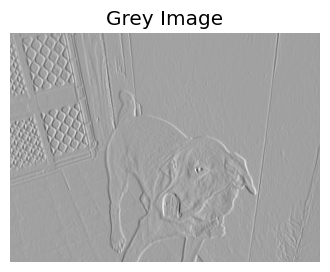

In [92]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(output, cmap='Greys')
ax.axis('off')
ax.set_title('Grey Image')
plt.show()

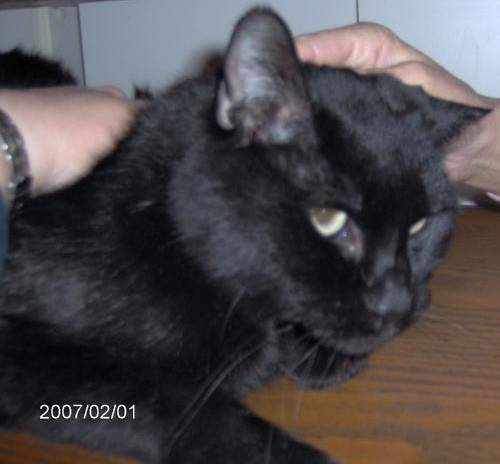

In [93]:
Image.open(cat_files[0])

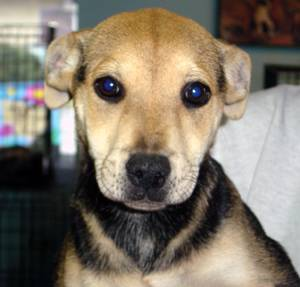

In [94]:
Image.open(dog_files[0])

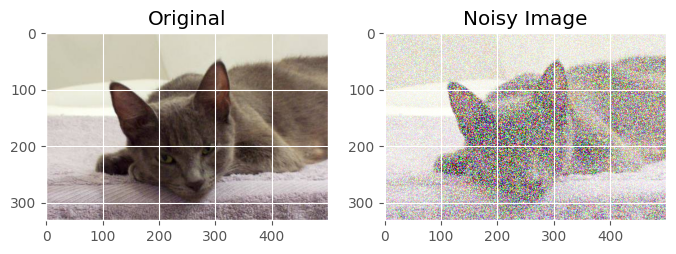

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, sigma=5):
    """
    Adds Gaussian noise to an image.
    :param image: Input image (NumPy array)
    :param mean: Mean of Gaussian noise
    :param sigma: Standard deviation of Gaussian noise
    :return: Noisy image
    """
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)  # Add noise to the image
    return noisy_image

# Load an image
random_num = random.randint(0, 12499)
image = cv2.imread(cat_files[random_num])  # Load image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Add noise
noisy_img = add_gaussian_noise(image)

# Display images
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(noisy_img)
plt.title("Noisy Image")

plt.show()


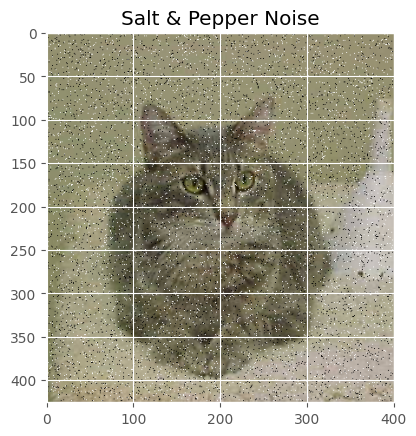

In [96]:
def add_salt_pepper_noise(image, prob=0.01):
    """
    Adds Salt & Pepper noise to an image.
    :param image: Input image (NumPy array)
    :param prob: Probability of noise
    :return: Noisy image
    """
    noisy_img = image.copy()
    num_pixels = int(prob * image.size)

    # Add salt (white) noise
    coords = [np.random.randint(0, i - 1, num_pixels) for i in image.shape[:2]]
    noisy_img[coords[0], coords[1], :] = 255  # White pixels

    # Add pepper (black) noise
    coords = [np.random.randint(0, i - 1, num_pixels) for i in image.shape[:2]]
    noisy_img[coords[0], coords[1], :] = 0  # Black pixels

    return noisy_img

# Load an image
random_num = random.randint(0, 12499)
image = cv2.imread(cat_files[random_num])  # Load image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Apply salt & pepper noise
sp_noisy_img = add_salt_pepper_noise(image)

# Display image
plt.imshow(sp_noisy_img)
plt.title("Salt & Pepper Noise")
plt.show()


# Download the augmented dataset folder - link

In [97]:
# import shutil
# from IPython.display import FileLink

# # Define the folder path you want to download
# folder_path = "./KaggleCatsDogs/train augmented/"
# zip_name = "train_augmented.zip"  # Output zip file

# # Create a zip archive
# shutil.make_archive(zip_name.replace('.zip', ''), 'zip', folder_path)

# # Create a download link
# FileLink(zip_name)